In [2]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)

# Hamiltonians

In [5]:
def aux_info(ham_func, ham_pars, ham_args, n_inp, n_layers, pars, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations """

    n_tot = n_inp*n_copies
    d = 2**n_tot
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]

    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]
   
    v0s = []
    v0s_der = []
    QFIs = []
    for p in ham_pars:        
        ham = ham_func(n_inp, p, *ham_args)
        ham_p = ham_func(n_inp, p+dp, *ham_args)
        ham_m = ham_func(n_inp, p-dp, *ham_args)
        ham_der = (ham_p - ham_m)/(2*dp)

        evals_ham, evecs_ham = eigh(ham)
        e0 = evals_ham[0]
        v0 = evecs_ham[:,0]
        e0_der = (v0.conj().T@ham_der@v0).real # Hellmann-Feynman theorem
        
        mat = ham - e0*eye(2**n_inp)
        mat_der = ham_der - e0_der*eye(2**n_inp) # in literature, the second term is absent for some reason
        
        v0_der = -pinv(mat, rcond=1e-12, hermitian=True)@mat_der@v0 # rcond is important! does not work with the default value
        # v0_der = sum([evecs_ham[:,i].conj().T@ham_der@v0/(evals_ham[i] - e0)*evecs_ham[:,i] for i in range(1, 2**n_inp) if evals_ham[i] - e0 != 0]) # other method, memory-inefficient
        
        ### checks; should be zeros ###
        # print(norm(mat_der@v0 + mat@v0_der))
        # print(norm((ham_der@v0 + ham@v0_der) - (e0_der*v0 + e0*v0_der)))
        # print()
    
        v0_der = sum([reduce(kron, [v0]*c + [v0_der] + [v0]*(n_copies - c - 1)) for c in range(n_copies)]) # memory-inefficient, but is a fancy one-liner
        v0 = reduce(kron, [v0]*n_copies)

        QFI = 4*(vdot(v0_der, v0_der) - vdot(v0_der, v0)*vdot(v0, v0_der)).real + 1e-10

        v0s.append(v0)
        v0s_der.append(v0_der)
        QFIs.append(QFI)  

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    for j in range(len(ham_pars)): # take a density matrix from the training set
        probs = [(v0s[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        probs_der = [2*(v0s_der[j].conj().T@proj@v0s[j]).real for proj in projs_u]
        
        expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
        expec_der = sum([ev*prob_der for ev, prob_der in zip(pars_est, probs_der)])
        disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
        
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs)

In [2]:
n_inp = 8
n_copies = 1
n_meas = n_inp*n_copies
n_tot = n_inp*n_copies
n_layers = 2
w_ls = 1e0
dp = 1e-5

w_var_1 = 1e-1
w_var_2 = 1e-4

ham_func = ising_ham
ham_args = []

save_path = r"/home/kardashin/Work/QPE/Results/Ising/"
file_info = r"n=%d-c=%d-m=%d-l=%d" %(n_inp, n_copies, n_meas, n_layers)

pars_1 = np.load(save_path + "Ising-pars-" + file_info + r"-w_ls=%f-w_var=%f.npy" %(w_ls, w_var_1))
pars_2 = np.load(save_path + "Ising-pars-" + file_info + r"-w_ls=%f-w_var=%f.npy" %(w_ls, w_var_2))

In [3]:
labels_train = np.load(save_path + "Ising-labels_train-" + "n=%d.npy" %n_inp)
labels_test = np.load(save_path + "Ising-labels_test-" + "n=%d.npy" %n_inp)

In [6]:
expecs_train_1, expecs_der_train_1, disps_train_1, CFIs_train_1, QFIs_train_1 = aux_info(ham_func, labels_train, ham_args, n_inp, n_layers, pars_1, 
                                                                                    n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs_train_2, expecs_der_train_2, disps_train_2, CFIs_train_2, QFIs_train_2 = aux_info(ham_func, labels_train, ham_args, n_inp, n_layers, pars_2, 
                                                                                    n_copies=n_copies, n_meas=n_meas, dp=dp)

expecs_test_1, expecs_der_test_1, disps_test_1, CFIs_test_1, QFIs_test_1 = aux_info(ham_func, labels_test, ham_args, n_inp, n_layers, pars_1, 
                                                                                    n_copies=n_copies, n_meas=n_meas, dp=dp)
expecs_test_2, expecs_der_test_2, disps_test_2, CFIs_test_2, QFIs_test_2 = aux_info(ham_func, labels_test, ham_args, n_inp, n_layers, pars_2, 
                                                                                    n_copies=n_copies, n_meas=n_meas, dp=dp)

biass_train_1 = expecs_train_1 - labels_train
biass_train_2 = expecs_train_2 - labels_train

biass_test_1 = expecs_test_1 - labels_test
biass_test_2 = expecs_test_2 - labels_test

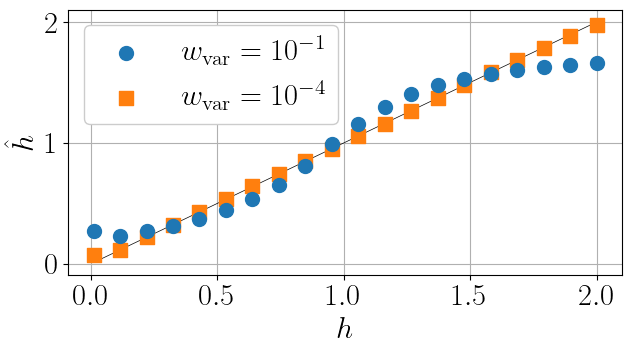

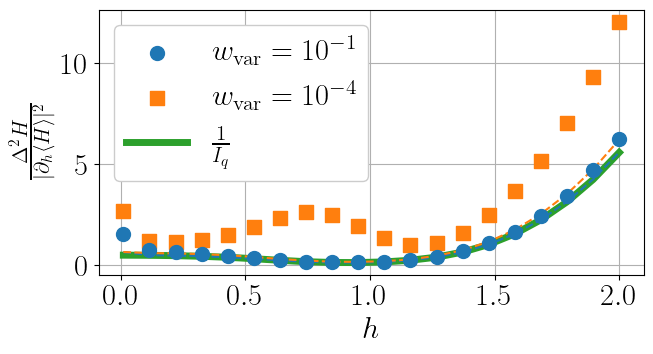

In [7]:
file_info = r"Ising-n_copies=%d-n_meas=%d=n_layers=%d-w_ls=%f-w_var=(%f,%f)" %(n_copies, n_meas, n_layers, w_ls, w_var_1, w_var_2)
save_path + file_info

matplotlib.rcParams.update({'font.size': 22})
plt.rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, color="C0", marker="o", s=100, label=r"$w_{\mathrm{var}}=10^{-1}$", zorder=10)
plt.scatter(labels_test, expecs_test_2, color="C1", marker="s", s=100, label=r"$w_{\mathrm{var}}=10^{-4}$", zorder=9)
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$h$")
plt.ylabel(r"$\hat{h}$")
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()#pad=0)
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True)#, bbox_inches='tight')#, pad_inches=0)
plt.show()

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_1/expecs_der_test_1**2, marker="o", s=100, label=r"$w_{\mathrm{var}}=10^{-1}$", zorder=10)
plt.scatter(labels_test, disps_test_2/expecs_der_test_2**2, marker="s", s=100, label=r"$w_{\mathrm{var}}=10^{-4}$", zorder=9)
plt.plot(np.sort(labels_test), 1/QFIs_test_1, color="C2", linewidth=5, linestyle="solid", label=r"$\frac{1}{I_q}$") # , label=r"$\frac{1}{I_q}$"
plt.plot(np.sort(labels_test), 1/CFIs_test_1, color="C0", linewidth=1.5, linestyle="dashed") # , label=r"$\frac{1}{I_c}$"
plt.plot(np.sort(labels_test), 1/CFIs_test_2, color="C1", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{|\partial_h \langle H \rangle |^2}$" )
plt.xlabel(r"$h$")
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()#pad=0)
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True)#, bbox_inches='teight')#, pad_inches=0)
plt.show()

### Bias compensation

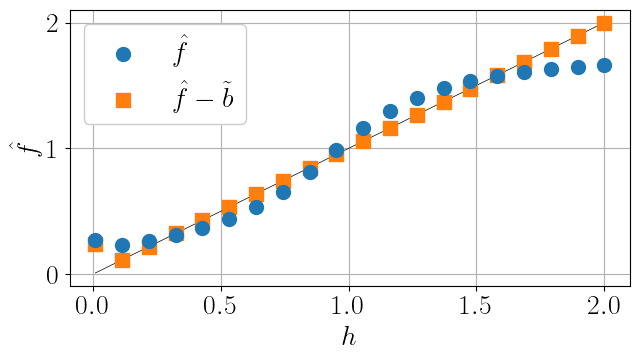

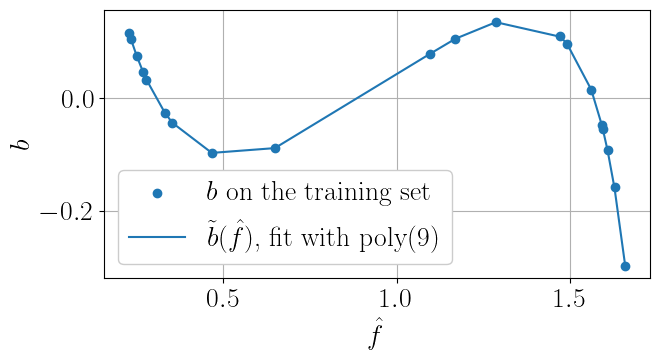

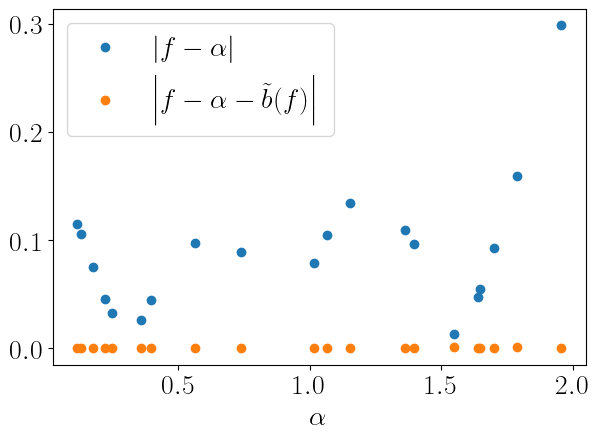

In [8]:
file_info = r"Ising-c=%d-m=%d-l=%d-w_ls=%f-w_var=%f" %(n_copies, n_meas, n_layers, w_ls, w_var_1)

m = 9
f_bias = np.poly1d(np.polyfit(expecs_train_1, biass_train_1, m))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, color="C0", marker="o", s=100, label=r"$\hat{f}$", zorder=10)
plt.scatter(labels_test, expecs_test_1 - f_bias(expecs_test_1), color="C1", marker="s", s=100, label=r"$\hat{f} - \tilde{b}$", zorder=9)
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$h$")
plt.ylabel(r"$\hat{f}$")
plt.grid()
plt.legend(framealpha=1)
# plt.tight_layout()#pad=1.25)
# plt.savefig(save_path + file_info + "-bias-comp.pdf", transparent=True)#, bbox_inches='tight')#, pad_inches=0)
plt.show()

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(expecs_train_1, biass_train_1, label=r"$b$ on the training set")
plt.plot(expecs_train_1, f_bias(expecs_train_1), label=r"$\tilde{b}(\hat{f})$, fit with $\mathrm{poly}(%d)$"%(m))
plt.xlabel(r"$\hat{f}$")# = \langle H \rangle_{\rho_\alpha}$")
plt.ylabel(r"$b$")
plt.grid()
plt.legend(framealpha=1)
# plt.ylim(-0.45, 0.2)
# plt.tight_layout()#pad=1.25)
# plt.savefig(save_path + file_info + "-bias-fit.pdf", transparent=True)#, bbox_inches='tight')#)
plt.show()

plt.scatter(labels_train, np.abs(expecs_train_1 - labels_train),  label=r"$|f - \alpha|$")
plt.scatter(labels_train, np.abs(expecs_train_1 - labels_train - f_bias(expecs_train_1)),  label=r"$\left|f - \alpha - \tilde{b}(f)\right|$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

# Random mixed state linear negativity 

In [13]:
def aux_info(dms, labels, n_layers, pars, n_copies=1, n_meas=0):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)

    obs_u = ansatz.conj().T@kron_A_N(diag(pars_est), d_diff)@ansatz
    obs_u_sq = obs_u@obs_u
    
    # projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    # projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]
    
    expecs = []
    disps = []
    # for j in range(len(labels)): # take a density matrix from the training set
    #     print(j, end="\r")
    #     probs = [trace(dms_cop[j]@proj).real for proj in projs_u]
    #     expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
    #     disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
    #     expecs.append(expec)
    #     disps.append(disp)
    for dm in dms_cop:
        expec = trace(dm@obs_u).real
        disp = trace(dm@obs_u_sq).real - expec**2
        expecs.append(expec)
        disps.append(disp)
        
    
    return array(expecs), array(disps)

In [14]:
n_inp = 2
n_train = 1000
n_test = 10000
mixed = True
marks = "neg"

w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(1e3)}#, "maxfun": int(1e10)}#

In [15]:
path = r"/home/kardashin/Work/QPE/Results/Entanglement/Negativity/"
info = "T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_train, w_ls, w_var, marks, mixed)

In [6]:
dms_train = np.load(path + info + "-dms_train.npy", allow_pickle=True)
labels_train = np.load(path + info + "-labels_train.npy", allow_pickle=True)
dms_test, labels_test = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
purities_test = [trace(dm@dm).real for dm in dms_test]

In [16]:
n_layers_1, n_layers_2, n_layers_3, n_layers_4 = 2, 2, 2, 2
n_copies_1, n_copies_2, n_copies_3, n_copies_4 = 1, 2, 3, 4
n_meas_1, n_meas_2, n_meas_3, n_meas_4 = n_inp*n_copies_1, n_inp*n_copies_2, n_inp*n_copies_3, n_inp*n_copies_4

pf_1 = "c=%d-m=%d-l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_1, n_meas_1, n_layers_1, n_train, w_ls, w_var, marks, mixed)
pf_2 = "c=%d-m=%d-l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_2, n_meas_2, n_layers_2, n_train, w_ls, w_var, marks, mixed)
pf_3 = "c=%d-m=%d-l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_3, n_meas_3, n_layers_3, n_train, w_ls, w_var, marks, mixed)
pf_4 = "c=%d-m=%d-l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_4, n_meas_4, n_layers_4, n_train, w_ls, w_var, marks, mixed)
pars_1 = np.load(path + pf_1 + "-pars.npy", allow_pickle=True)
pars_2 = np.load(path + pf_2 + "-pars.npy", allow_pickle=True)
pars_3 = np.load(path + pf_3 + "-pars.npy", allow_pickle=True)
pars_4 = np.load(path + pf_4 + "-pars.npy", allow_pickle=True)

In [17]:
expecs_train_1, disps_train_1 = aux_info(dms_train, labels_train, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)
expecs_test_1, disps_test_1 = aux_info(dms_test, labels_test, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)

expecs_train_2, disps_train_2 = aux_info(dms_train, labels_train, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)
expecs_test_2, disps_test_2 = aux_info(dms_test, labels_test, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)

expecs_train_3, disps_train_3 = aux_info(dms_train, labels_train, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)
expecs_test_3, disps_test_3 = aux_info(dms_test, labels_test, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)

expecs_train_4, disps_train_4 = aux_info(dms_train, labels_train, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)
expecs_test_4, disps_test_4 = aux_info(dms_test, labels_test, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)

Sum error: 0.25100603221145973


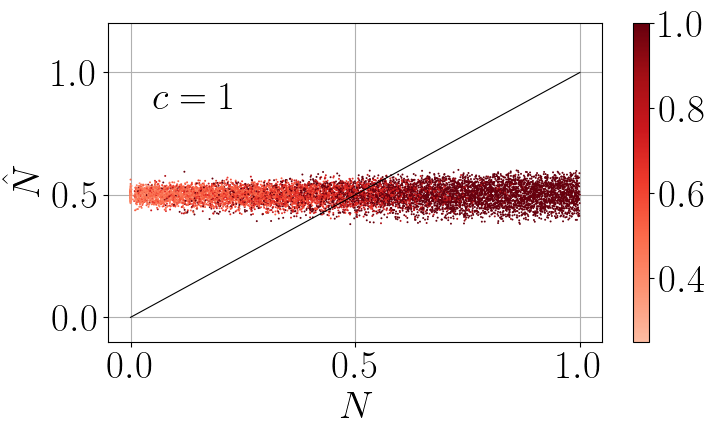

Sum error: 0.03725287668916529


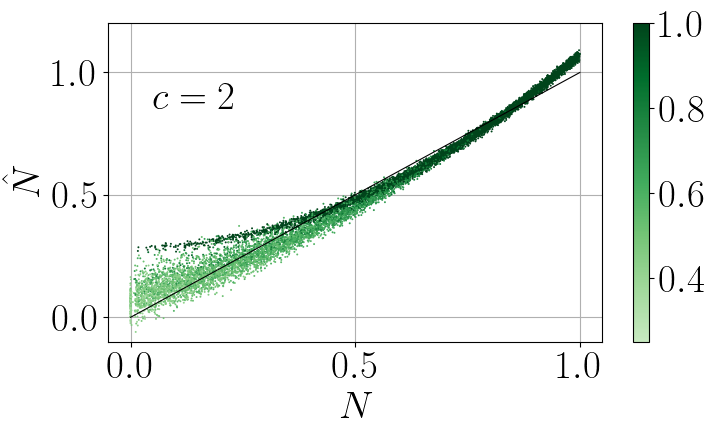

Sum error: 0.039262128472694335


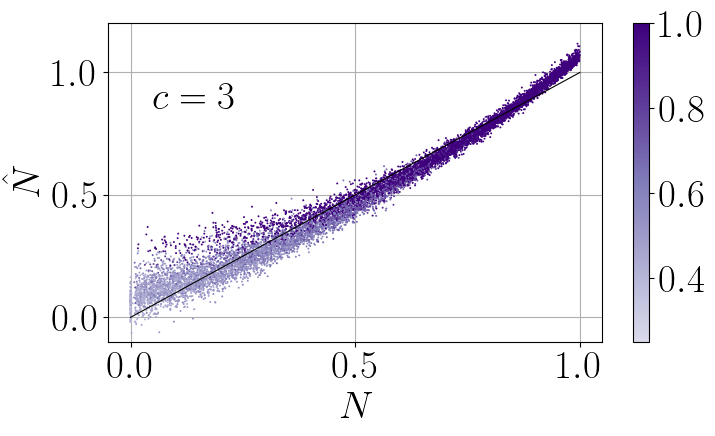

Sum error: 0.02063335200627407


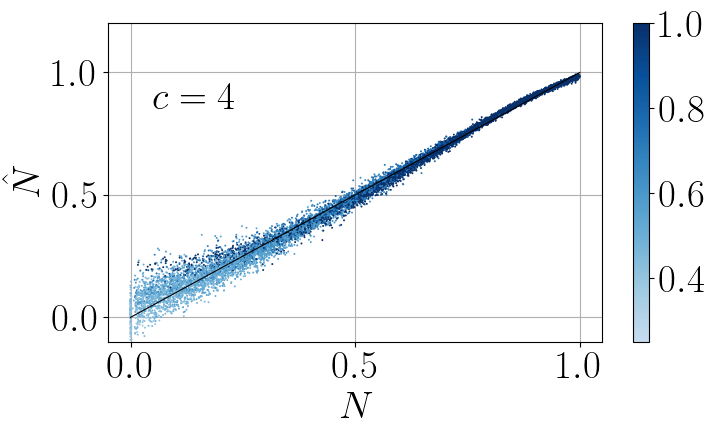

In [18]:
matplotlib.rcParams.update({'font.size': 28})

sum_err_test_1 = sum(np.abs(expecs_test_1 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_1)
cmap_name_1 = "Reds"
cmap_1 = plt.get_cmap(cmap_name_1)
colors_1 = cmap_1(np.linspace(0.25, 1., cmap_1.N))
cmap_1 = LinearSegmentedColormap.from_list(cmap_name_1, colors_1)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, c=purities_test, cmap=cmap_1, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
plt.text(0.05, 0.85, r"$c=1$")
plt.ylim(-0.1, 1.2)
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies_1, n_layers_1, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_1 + ".pdf", transparent=True, bbox_inches='tight')
plt.show()

sum_err_test_2 = sum(np.abs(expecs_test_2 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_2)
cmap_name_2 = "Greens"
cmap_2 = plt.get_cmap(cmap_name_2)
colors_2 = cmap_2(np.linspace(0.25, 1., cmap_2.N))
cmap_2 = LinearSegmentedColormap.from_list(cmap_name_2, colors_2)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_2, c=purities_test, cmap=cmap_2, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
plt.text(0.05, 0.85, r"$c=2$")
plt.ylim(-0.1, 1.2)
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_2 + ".pdf", transparent=True, bbox_inches='tight')
plt.show()

sum_err_test_3 = sum(np.abs(expecs_test_3 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_3)
cmap_name_3 = "Purples"
cmap_3 = plt.get_cmap(cmap_name_3)
colors_3 = cmap_3(np.linspace(0.25, 1., cmap_3.N))
cmap_3 = LinearSegmentedColormap.from_list(cmap_name_3, colors_3)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_3, c=purities_test, cmap=cmap_3, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
plt.text(0.05, 0.85, r"$c=3$")
plt.ylim(-0.1, 1.2)
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_3 + ".pdf", transparent=True, bbox_inches='tight')
plt.show()

sum_err_test_4 = sum(np.abs(expecs_test_4 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_4)
cmap_name_4 = "Blues"
cmap_4 = plt.get_cmap(cmap_name_4)
colors_4 = cmap_4(np.linspace(0.25, 1., cmap_4.N))
cmap_4 = LinearSegmentedColormap.from_list(cmap_name_4, colors_4)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_4, c=purities_test, cmap=cmap_4, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
plt.ylim(-0.1, 1.2)
plt.text(0.05, 0.85, r"$c=4$")
plt.ylim(-0.1, 1.2)
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_4 + ".pdf", transparent=True, bbox_inches='tight')
plt.show()

Error: 0.02063335200627407


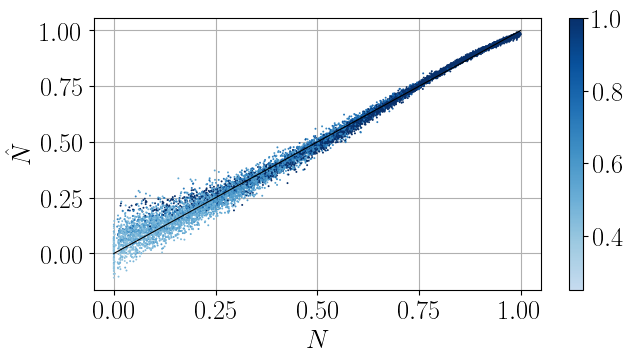

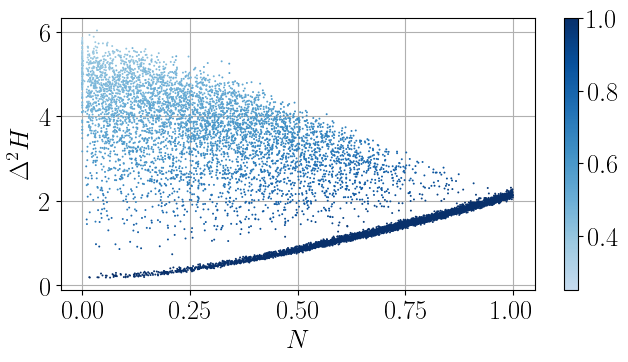

In [19]:
matplotlib.rcParams.update({'font.size': 19})

purities_test = [trace(dm@dm).real for dm in dms_test]

# cmap_name = "RdYlBu_r"
cmap_name = "Blues"
# cmap_name = "cool"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0.25, 1., cmap.N))
# colors = cmap(np.linspace(0, 0.65, cmap.N))
# colors = cmap(np.linspace(0., 1, cmap.N))
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

sum_err_test = sum(np.abs(expecs_test_4 - array(labels_test)))/n_test
print("Error:", sum_err_test)

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N$")
plt.ylabel(r"$\hat{N}$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()#pad=0)
# plt.savefig(path + pf_4 + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 4))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, disps_test_4, c=purities_test, cmap=cmap, s=2, edgecolor='none')
plt.xlabel(r"$N$")
plt.ylabel(r"$\Delta^2 H$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()#pad=0)
# plt.savefig(path + pf_4 + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

# Random mixed state squared negativity 

In [1]:
def aux_info(dms, labels, n_layers, pars, n_copies=1, n_meas=0):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
    d_diff = 2**(n_tot - n_meas)
    
    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    # CX_cascade = cx_cascade(n_tot)
    # ansatz = hea_cx_rzrx(n_tot, n_layers, CX_cascade, pars_ans)

    obs_u = ansatz.conj().T@kron_A_N(diag(pars_est), d_diff)@ansatz
    obs_u_sq = obs_u@obs_u
    
    # projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    # projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]
    
    expecs = []
    disps = []
    # for j in range(len(labels)): # take a density matrix from the training set
    #     print(j, end="\r")
    #     probs = [trace(dms_cop[j]@proj).real for proj in projs_u]
    #     expec = sum([ev*prob for ev, prob in zip(pars_est, probs)])
    #     disp = sum([ev**2*prob for ev, prob in zip(pars_est, probs)]) - expec**2
    #     expecs.append(expec)
    #     disps.append(disp)
    for dm in dms_cop:
        expec = trace(dm@obs_u).real
        disp = trace(dm@obs_u_sq).real - expec**2
        expecs.append(expec)
        disps.append(disp)
        
    
    return array(expecs), array(disps)

In [2]:
n_inp = 2
n_train = 1000
n_test = 10000
mixed = True
marks = "neg"

w_ls = 1e0
w_var = 1e-4
method = "BFGS"
options = {"maxiter": int(1e3)}#, "maxfun": int(1e10)}#

In [3]:
path = r"/home/kardashin/Work/QPE/Results/Entanglement/Squared negativity/"
info = "T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_train, w_ls, w_var, marks, mixed)

In [4]:
dms_train = np.load(path + info + "-dms_train.npy", allow_pickle=True)
labels_train_lin = np.load(path + info + "-labels_train_lin.npy", allow_pickle=True)
dms_test, labels_test_lin = gen_even_ent_data(n_test, n_inp=n_inp, mixed=mixed, marks=marks)
purities_test = [trace(dm@dm).real for dm in dms_test]

In [5]:
n_layers_1, n_layers_2, n_layers_3, n_layers_4 = 2, 2, 2, 2
n_copies_1, n_copies_2, n_copies_3, n_copies_4 = 1, 2, 3, 4
n_meas_1, n_meas_2, n_meas_3, n_meas_4 = n_inp*n_copies_1, n_inp*n_copies_2, n_inp*n_copies_3, n_inp*n_copies_4

pf_1 = "c=%d-m=%d=l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_1, n_meas_1, n_layers_1, n_train, w_ls, w_var, marks, mixed)
pf_2 = "c=%d-m=%d=l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_2, n_meas_2, n_layers_2, n_train, w_ls, w_var, marks, mixed)
pf_3 = "c=%d-m=%d=l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_3, n_meas_3, n_layers_3, n_train, w_ls, w_var, marks, mixed)
pf_4 = "c=%d-m=%d=l=%d-T=%d-w_ls=%f-w_var=%f-marks=%s-mixed=%s" %(n_copies_4, n_meas_4, n_layers_4, n_train, w_ls, w_var, marks, mixed)
pars_1 = np.load(path + pf_1 + "-pars.npy", allow_pickle=True)
pars_2 = np.load(path + pf_2 + "-pars.npy", allow_pickle=True)
pars_3 = np.load(path + pf_3 + "-pars.npy", allow_pickle=True)
pars_4 = np.load(path + pf_4 + "-pars.npy", allow_pickle=True)

In [6]:
labels_train = array(labels_train_lin)**2
labels_test = array(labels_test_lin)**2

In [9]:
expecs_train_1, disps_train_1 = aux_info(dms_train, labels_train, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)
expecs_test_1, disps_test_1 = aux_info(dms_test, labels_test, n_layers_1, pars_1, n_copies=n_copies_1, n_meas=n_meas_1)

expecs_train_2, disps_train_2 = aux_info(dms_train, labels_train, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)
expecs_test_2, disps_test_2 = aux_info(dms_test, labels_test, n_layers_2, pars_2, n_copies=n_copies_2, n_meas=n_meas_2)

expecs_train_3, disps_train_3 = aux_info(dms_train, labels_train, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)
expecs_test_3, disps_test_3 = aux_info(dms_test, labels_test, n_layers_3, pars_3, n_copies=n_copies_3, n_meas=n_meas_3)

expecs_train_4, disps_train_4 = aux_info(dms_train, labels_train, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)
expecs_test_4, disps_test_4 = aux_info(dms_test, labels_test, n_layers_4, pars_4, n_copies=n_copies_4, n_meas=n_meas_4)

Sum error: 0.25782230096367065


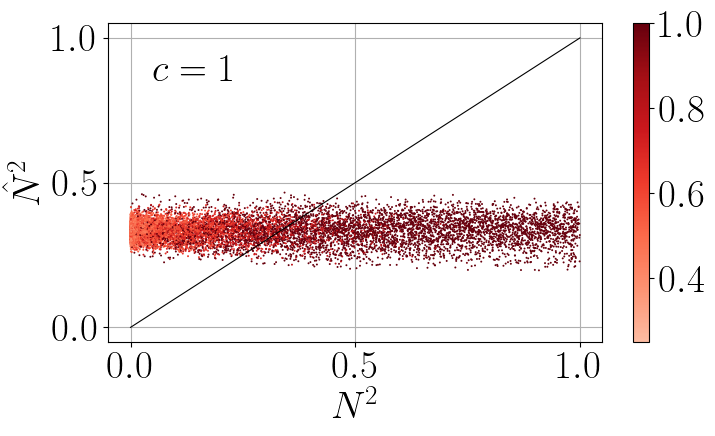

Sum error: 0.03209764254627943


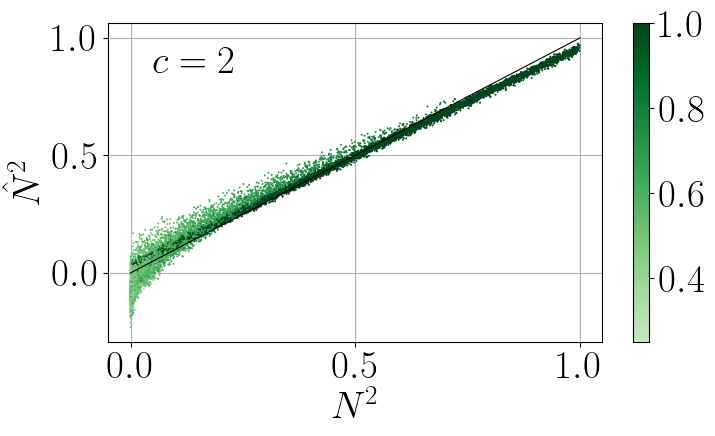

Sum error: 0.03248668433609784


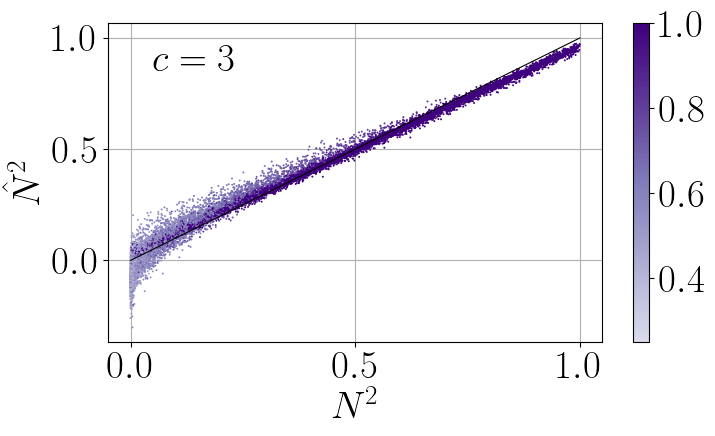

Sum error: 0.02270166599926542


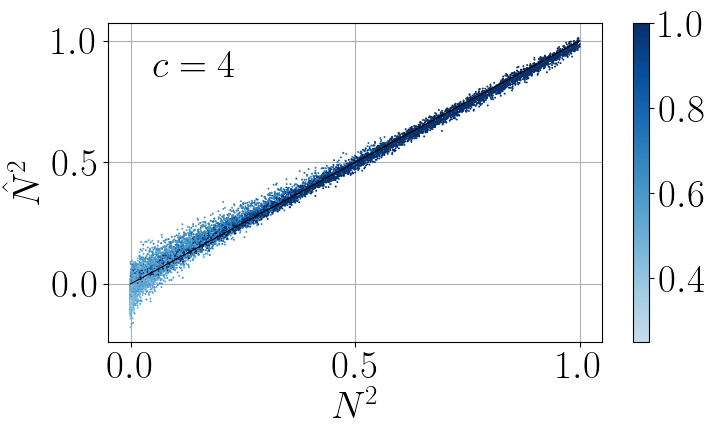

In [10]:
matplotlib.rcParams.update({'font.size': 28})

sum_err_test_1 = sum(np.abs(expecs_test_1 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_1)
cmap_name_1 = "Reds"
cmap_1 = plt.get_cmap(cmap_name_1)
colors_1 = cmap_1(np.linspace(0.25, 1., cmap_1.N))
cmap_1 = LinearSegmentedColormap.from_list(cmap_name_1, colors_1)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_1, c=purities_test, cmap=cmap_1, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N^2$")
plt.ylabel(r"$\hat{N}^2$")
plt.text(0.05, 0.85, r"$c=1$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_1 + "-sq.pdf", transparent=True, bbox_inches='tight')
plt.show()

sum_err_test_2 = sum(np.abs(expecs_test_2 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_2)
cmap_name_2 = "Greens"
cmap_2 = plt.get_cmap(cmap_name_2)
colors_2 = cmap_2(np.linspace(0.25, 1., cmap_2.N))
cmap_2 = LinearSegmentedColormap.from_list(cmap_name_2, colors_2)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_2, c=purities_test, cmap=cmap_2, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N^2$")
plt.ylabel(r"$\hat{N}^2$")
plt.text(0.05, 0.85, r"$c=2$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_2 + "-sq.pdf", transparent=True, bbox_inches='tight')
plt.show()

sum_err_test_3 = sum(np.abs(expecs_test_3 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_3)
cmap_name_3 = "Purples"
cmap_3 = plt.get_cmap(cmap_name_3)
colors_3 = cmap_3(np.linspace(0.25, 1., cmap_3.N))
cmap_3 = LinearSegmentedColormap.from_list(cmap_name_3, colors_3)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_3, c=purities_test, cmap=cmap_3, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N^2$")
plt.ylabel(r"$\hat{N}^2$")
plt.text(0.05, 0.85, r"$c=3$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_3 + "-sq.pdf", transparent=True, bbox_inches='tight')
plt.show()

sum_err_test_4 = sum(np.abs(expecs_test_4 - array(labels_test)))/n_test
print("Sum error:", sum_err_test_4)
cmap_name_4 = "Blues"
cmap_4 = plt.get_cmap(cmap_name_4)
colors_4 = cmap_4(np.linspace(0.25, 1., cmap_4.N))
cmap_4 = LinearSegmentedColormap.from_list(cmap_name_4, colors_4)
plt.figure(figsize=(8, 5))
plt.rcParams['axes.axisbelow'] = True
plt.scatter(labels_test, expecs_test_4, c=purities_test, cmap=cmap_4, s=2, edgecolor='none') # , color="dodgerblue"
plt.plot(linspace(0, 1), linspace(0, 1), linestyle="-", linewidth=0.8, color="black")
plt.xlabel(r"$N^2$")
plt.ylabel(r"$\hat{N}^2$")
plt.text(0.05, 0.85, r"$c=4$")
# plt.title(r"$c = %d$, $l = %d$, $E = %f$" %(n_copies, n_layers, sum_err_test))
plt.colorbar()
plt.clim(0.25, 1)
plt.grid()
plt.tight_layout()
# plt.savefig(path + pf_4 + "-sq.pdf", transparent=True, bbox_inches='tight')
plt.show()